# Class 8 - Parallelism in Julia

Today we'll talk a bit about Julia's built-in tecniques for taking advantage of parallelism, as well as Julia's MPI interface and using GPUs.

* See [farmshare.md](farmshare.md) to see how to connect to Stanford's farmshare cluster.
* [Julia's Parallel Documentation](https://docs.julialang.org/en/stable/manual/parallel-computing)

## Example: Monte Carlo Simulations

One of the many ways that computers have aided science is through simulation.  Sometimes you may not have a closed-form way to access a quantity of interest, and can obtain a good guess through running many simulations with parameters drawn from a distribution, and looking at the average behavior of your model.  This class of methods is known as [Monte Carlo methods](https://en.wikipedia.org/wiki/Monte_Carlo_method).  

One of the benefits of Monte Carlo methods is that they are often trivially parallelizable, since you can run independent experiments on separate processes, and then aggregate the results in a single round of communication at the end.

One of the great uses of Monte Carlo methods is [integration](https://en.wikipedia.org/wiki/Monte_Carlo_integration), which becomes increasingly attractive over high-dimensional domains.  The cannonical example is estimating $\pi$ by integrating a circle on a square domian.

The area of a circle with unit radius is $\pi r^2 = \pi$.
The area of a square on $[-1, 1]^2$ is 4.  If we place the unit circle in this square, the ratio of their areas is $\pi/4$.  The idea is that we sample uniformly on this square, and then see what portion of the points lie in the circle.  We know that this ratio should be approximately $\pi/4$, so re multiply the ratio by 4 to obtain our approximation of $\pi$.

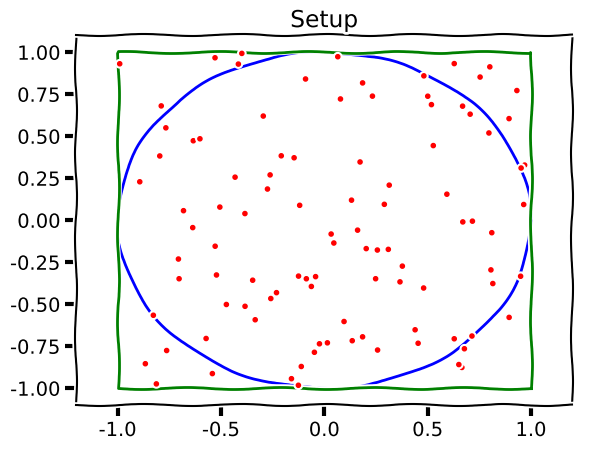

/usr/lib64/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'xkcd', u'Humor Sans', u'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [1]:
using PyPlot
θ = linspace(0,2π,1000)
circ_xs = cos.(θ)
circ_ys = sin.(θ)

sq_xs = [ 1, 1,-1,-1, 1]
sq_ys = [-1, 1, 1,-1,-1]

r_xs = rand(100) * 2 - 1
r_ys = rand(100) * 2 - 1

xkcd()
plot(circ_xs,circ_ys, "b-", sq_xs, sq_ys, "g-", r_xs, r_ys, "r.")
axis([-1.2, 1.2, -1.1, 1.1])
title("Setup")
show()
;

In [2]:
function π_monte_carlo(n_samples::Int64)
    n_circle = 0
    for i=1:n_samples
        x = rand() * 2 - 1
        y = rand() * 2 - 1
        r2 = x^2 + y^2
        if r2 <= 1
            n_circle += 1
        end
    end
    return (n_circle / n_samples) * 4
end

@time π_monte_carlo(10000000)

  0.107387 seconds (5.10 k allocations: 267.645 KiB)


3.1415896

In [3]:
errors = Array{Float64}(0)
n_pts = 2.^(6:30) # 2^30 ≈ 1 billion
for n_samples in n_pts
    println("n_samples = $n_samples")
    tic()
    push!(errors, π_monte_carlo(n_samples) - π)
    t = toq()
    tstr = @sprintf("%.3e",t)
    println("  $tstr sec.")
end
;

n_samples = 64
  4.497e-03 sec.
n_samples = 128
  1.095e-05 sec.
n_samples = 256
  4.538e-06 sec.
n_samples = 512
  6.249e-06 sec.
n_samples = 1024
  1.065e-05 sec.
n_samples = 2048
  1.964e-05 sec.
n_samples = 4096
  3.882e-05 sec.
n_samples = 8192
  7.600e-05 sec.
n_samples = 16384
  1.861e-04 sec.
n_samples = 32768
  3.100e-04 sec.
n_samples = 65536
  6.077e-04 sec.
n_samples = 131072
  1.213e-03 sec.
n_samples = 262144
  2.420e-03 sec.
n_samples = 524288
  4.847e-03 sec.
n_samples = 1048576
  9.747e-03 sec.
n_samples = 2097152
  1.947e-02 sec.
n_samples = 4194304
  3.942e-02 sec.
n_samples = 8388608
  7.816e-02 sec.
n_samples = 16777216
  1.670e-01 sec.
n_samples = 33554432
  3.369e-01 sec.
n_samples = 67108864
  7.467e-01 sec.
n_samples = 134217728
  1.429e+00 sec.
n_samples = 268435456
  2.656e+00 sec.
n_samples = 536870912
  5.219e+00 sec.
n_samples = 1073741824
  1.061e+01 sec.


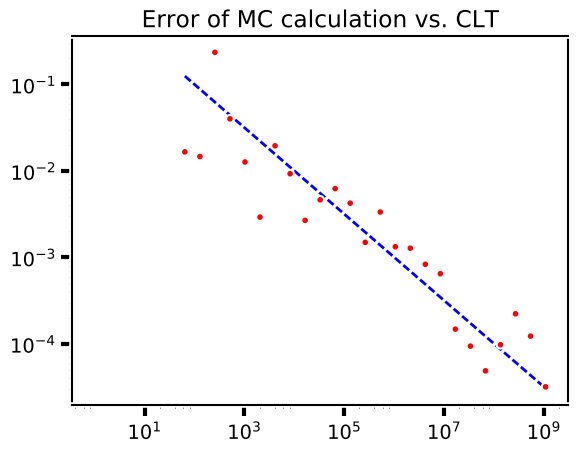

In [4]:
using PyPlot
xkcd(false)
show()
zx = [1, maximum(n_pts)]
zy = [0, 0]
semilogx(zx, zy ,"k--", n_pts, errors, ".r" )
title("Error of MC calculation")
show()

exp_acc = 1.0 ./ sqrt.(n_pts)

loglog(n_pts, exp_acc, "b--", n_pts, abs.(errors), ".r")
title("Error of MC calculation vs. CLT")
show()
;

It takes us ~10 sec. to estimate $\pi$ on a billion points. However, this used only one core on the machine.  What if we want to use more?  

## Using more than one process

If you're starting up Julia in a terminal, you can use
```
julia -p 4
```
To indicate that 4 processes are available.  If you're using a IJulia notebook or already have julia running, you can add processes with `addprocs()`:

In [5]:
@show nprocs()
addprocs(3)
@show nprocs()

nprocs() = 1
nprocs() = 4


4

(my machine has 4 cores).  Now, Julia will know that it can use up to 4 separate processes, but when you're writing code, you you need to explicitly use them.

In [6]:
# spawns process that generates a random matrix
m = @spawn randn(2,2)

Future(2, 1, 5, Nullable{Any}())

In [7]:
# returns the answer from the process we spawned
fetch(m)

2×2 Array{Float64,2}:
  1.61979   -2.06212 
 -0.460107  -0.345904

you can also request that the call spawn on a particular process

In [8]:
# spawn at process 2
m = @spawnat 2 randn(2,2)

Future(2, 1, 7, Nullable{Any}())

In [9]:
fetch(m)

2×2 Array{Float64,2}:
 -0.277744   0.195801
  0.578476  -0.153635

In [10]:
# the same thing can be done with the remotecall function
m = remotecall(randn, 4, 2, 2)

Future(4, 1, 9, Nullable{Any}())

In [11]:
fetch(m)

2×2 Array{Float64,2}:
 -0.791173  2.47341 
  0.460734  0.539565

You need to make sure that all processes have access to functions that you define.  In order to define a function on all processes use the `@everywhere` macro

In [12]:
function sum_test(a, b)
    a + b
end

sum_test (generic function with 1 method)

In [13]:
m = @spawn sum_test(1,2)

Future(3, 1, 11, Nullable{Any}())

In [14]:
fetch(m)

LoadError: [91mOn worker 3:
[91mUndefVarError: #sum_test not defined[39m
deserialize_datatype at ./serialize.jl:973
handle_deserialize at ./serialize.jl:677
deserialize at ./serialize.jl:637
handle_deserialize at ./serialize.jl:684
deserialize_global_from_main at ./distributed/clusterserialize.jl:154
foreach at ./abstractarray.jl:1733
deserialize at ./distributed/clusterserialize.jl:56
handle_deserialize at ./serialize.jl:726
deserialize at ./serialize.jl:637
handle_deserialize at ./serialize.jl:681
deserialize at ./serialize.jl:637
handle_deserialize at ./serialize.jl:684
deserialize_msg at ./distributed/messages.jl:98
message_handler_loop at ./distributed/process_messages.jl:161
process_tcp_streams at ./distributed/process_messages.jl:118
#99 at ./event.jl:73[39m

In [15]:
@everywhere function sum_test(a, b)
    a + b
end

In [16]:
m = @spawn sum_test(1,2)
fetch(m)

3

If you're loading modules, `using` will load them on all processes, but `include()` will not.

In [19]:
@everywhere using Distributions
# spawn a process to generate an exponential random variable
d = @spawn Exponential()

Future(3, 1, 26, Nullable{Any}())

In [20]:
d2 = fetch(d)
rand(d2)

0.08761071996262869

You can control which process is used with `@spawnat`

In [ ]:
p = @spawnat 2 1+1

In [ ]:
fetch(p)

If you want a result immediately, you can use `remotecall_fetch()`. The first argument is the function to call.  The second argument is the process number to spawn the call at.  The remaining arguments are the inputs to the function

In [21]:
remotecall_fetch(+, 2, 3, 4)

7

The spawn/fetch commands are great for spinning off function evaluations.  If you want something that looks like a parallel for-loop, you can use the `@parallel` macro.  Note that this example does something like a MPI gather.

In [22]:
nheads = @parallel (+) for i=1:200000000
  Int(rand(Bool))
end

99999193

When you use a parallel for-loop, you should make sure that the inner contents of the loop are independent of each other, since you aren't controlling evaluation order, or which process is doing what.  Note that every process also uses its own copy of data, so something like the following will not work like you might wish it to.

In [24]:
a = rand(10)
@parallel for i = 1:100
    a[i] = 1
end
@show a
;

a = [0.987713, 0.415403, 0.0260959, 0.478102, 0.982906, 0.101166, 0.0594184, 0.0142452, 0.889992, 0.342526]


## Exercise 1

* Modify the Monte Carlo calculation of $\pi$ above to use more than one process. (There's more than one way to do this!)
* How fast is your modified version compared to the single process version?
* Can you add the `@simd` macro to the for-loop?  How does this compare with parallelization?  Can you mix parallelization and `@simd`?

In [29]:
# some answers for the pi monte-carlo question

function π_monte_carlo(n_samples::Int64)
    n_circle = 0
    for i=1:n_samples
        x = rand() * 2 - 1
        y = rand() * 2 - 1
        r2 = x^2 + y^2
        if r2 <= 1
            n_circle += 1
        end
    end
    return (n_circle / n_samples) * 4
end

@everywhere function π_monte_carlo_simd(n_samples::Int64)
    n_circle = 0
    @simd for i=1:n_samples
        x = rand() * 2 - 1
        y = rand() * 2 - 1
        r2 = x^2 + y^2
        if r2 <= 1
            n_circle += 1
        end
    end
    return (n_circle / n_samples) * 4
end



function π_monte_carlo_parallel(n_samples::Int64)
    n_circle = @parallel (+) for i=1:n_samples
        x = rand() * 2 - 1
        y = rand() * 2 - 1
        r2 = x^2 + y^2
        Int64(r2 <= 1)
    end
    return (n_circle / n_samples) * 4
end

function π_monte_carlo_parallel_simd(n_samples::Int64)
    num_proc = nprocs()
    n_per_proc = div(n_samples, num_proc)
    jobs = []
    # create a job on each worker process
    for proc = num_proc:-1:2
        push!(jobs, @spawnat proc π_monte_carlo_simd(n_per_proc) )
    end
    #n_circle = remotecall_fetch(π_monte_carlo_simd, 1, n_per_proc + mod(n_samples, num_proc))
    # call on the master process as well
    n_circle = π_monte_carlo_simd(n_per_proc + mod(n_samples, num_proc))
    for proc = num_proc:-1:2
        n_circle += fetch(pop!(jobs))
    end
    return n_circle/num_proc
end
;

In [27]:
n = 100000000
@show n
println("Naive Monte Carlo")
@time a1 = π_monte_carlo(n)
@show a1
println("SIMD Monte Carlo")
@time a2 = π_monte_carlo_simd(n)
@show a2
println("Parallel Monte Carlo")
@time a3 = π_monte_carlo_parallel(n)
@show a3
println("Parallel SIMD Monte Carlo")
@time a4 = π_monte_carlo_parallel_simd(n)
@show a4
;

n = 100000000
Naive Monte Carlo
  1.005607 seconds (5 allocations: 176 bytes)
a1 = 3.14162096
SIMD Monte Carlo
  0.565880 seconds (5 allocations: 176 bytes)
a2 = 3.14187372
Parallel Monte Carlo
  0.331146 seconds (1.14 k allocations: 74.516 KiB)
a3 = 3.14161436
Parallel SIMD Monte Carlo
  0.281174 seconds (1.17 k allocations: 58.984 KiB)
a4 = 3.1416999199999998


# Arrays

As mentioned above, if you wish to have multiple processes work on a single array you need to go above an beyond the limitiations of a standard array.  There are two types of arrays you may wish to use for parallel/distributed computations:

* [Shared Arrays](https://docs.julialang.org/en/stable/manual/parallel-computing.html#man-shared-arrays-1) - built into Julia - all processes can access any element of the array
* [Distributed Arrays](https://github.com/JuliaParallel/DistributedArrays.jl) - package through JuliaParallel - array elements are distributed over processes.

### Shared Arrays

[Shared Arrays](https://docs.julialang.org/en/stable/manual/parallel-computing.html#man-shared-arrays-1) are accessible from all processes and maintain the same data.  This is useful for taking advantage of all processes on your computer.

In [30]:
n_add = 4 - nprocs()
addprocs(n_add)
@show nprocs()
;

nprocs() = 4


In [34]:
fetch(@spawn myid())

2

In [31]:
S = SharedArray{Int64}((3,4), init = S -> S[Base.localindexes(S)] = myid())

3×4 SharedArray{Int64,2}:
 2  2  3  4
 2  3  3  4
 2  3  4  4

The first argument is the type of the array elements, the second argument is a tuple of dimensions, the (optional) third argument is an initialization function, and the (optional) fourth argument denotes what processes the Shared Array should be shared on.

In [35]:
S = SharedArray{Int64}((3,4), init = S -> S[indexpids(S):length(procs(S)):length(S)] = myid())

3×4 SharedArray{Int64,2}:
 2  2  2  2
 3  3  3  3
 4  4  4  4

In [38]:
p = @spawnat 2 S[1] = 7
fetch(p)
S # displayed by process 1

3×4 SharedArray{Int64,2}:
 7  2  2  2
 3  3  3  3
 4  4  4  4

In [40]:
# test matrix-vector mulitplication
n = 1000
A = randn(n,n)
S = SharedArray{Float64}(A)
x = randn(n)
@time bA = A*x
@time bS = S*x
;

  0.000936 seconds (5 allocations: 8.094 KiB)
  0.000923 seconds (5 allocations: 8.094 KiB)


In [41]:
# you can use the @parallel macro with SharedArrays
n = 10
v = SharedArray{Int64}(n)
@parallel for i = 1:n
   v[i] = i 
end
v

10-element SharedArray{Int64,1}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10

### Distributed Arrays

[Distributed Arrays](https://github.com/JuliaParallel/DistributedArrays.jl) are offered from [Julia Parallel](https://github.com/JuliaParallel) to distribute an array over several processes.  If you've done distributed linear algebra before, this is probably more familiar than the SharedArray.

In [42]:
using DistributedArrays

In [43]:
B = drandn(5, 5)
println(B)
A = @DArray [i+j for i = 1:5, j = 1:5]
println(A)
;

[0.581306 1.10146 -0.957216 -0.649343 0.6035; 0.862821 -1.09024 1.01636 0.350388 0.0450718; 0.253511 -0.737495 1.5829 0.878414 2.95987; 1.23474 -0.625996 0.878136 0.309217 -0.014155; -1.93826 -0.91279 0.996988 -0.203504 1.73837]
[2 3 4 5 6; 3 4 5 6 7; 4 5 6 7 8; 5 6 7 8 9; 6 7 8 9 10]


In [46]:
# show distribution pattern of array
A = @DArray [myid() for i=1:10, j=1:10]

10×10 DistributedArrays.DArray{Int64,2,Array{Int64,2}}:
 2  2  2  3  3  3  3  4  4  4
 2  2  2  3  3  3  3  4  4  4
 2  2  2  3  3  3  3  4  4  4
 2  2  2  3  3  3  3  4  4  4
 2  2  2  3  3  3  3  4  4  4
 2  2  2  3  3  3  3  4  4  4
 2  2  2  3  3  3  3  4  4  4
 2  2  2  3  3  3  3  4  4  4
 2  2  2  3  3  3  3  4  4  4
 2  2  2  3  3  3  3  4  4  4

In [47]:
v = @DArray [myid() for i = 1:10]

10-element DistributedArrays.DArray{Int64,1,Array{Int64,1}}:
 2
 2
 2
 3
 3
 3
 3
 4
 4
 4

Distributed arrays will change the order of operations, so you should expect to see differences due to floating point errors when you perform operations with DArrays.

In [48]:
A = randn(100,100)
@show s1 = sum(A)
D = distribute(A)
@show s2 = sum(D)
@show s1 - s2
;

s1 = sum(A) = 43.91128697501765
s2 = sum(D) = 43.91128697501762
s1 - s2 = 3.552713678800501e-14


In [50]:
# test matrix-vector mulitplication
n = 2000
A = randn(n,n)
@show size(A)
D = distribute(A)
x = randn(n)
dx = distribute(x)
@show size(x)
@time bA = A*x
@time bD = D*dx
;

size(A) = (2000, 2000)
size(x) = (2000,)
  0.004168 seconds (5 allocations: 15.906 KiB)
  0.006973 seconds (765 allocations: 59.141 KiB)


In [51]:
typeof(bD)

DistributedArrays.DArray{Float64,1,Array{Float64,1}}

## Exercise 2

* Can you use linear algebra routines (such as SVD) on SharedArrays?  What about DArrays?  What is the type of the output?

# Using Julia with MPI

Most of what we've considered above is useful for using multiple cores on a single machine.  What if you want to run Julia on a cluster?  Julia provides a [MPI package](https://github.com/JuliaParallel/MPI.jl) that allows you to run Julia scripts with `mpirun` just as you would with C/Fortran binaries.

If you haven't used it before, [MPI](https://computing.llnl.gov/tutorials/mpi/) is the Message Passing Interface Standard.  The standard has several implementations - the most popular are [MPICH](https://www.mpich.org/) and [OpenMPI](http://www.open-mpi.org/) (both are open source), which you can get for your system using almost any repository manager.  Corn.stanford has OpenMPI, I have MPICH. In practice, the two are mostly interchangable, although they use slightly different syntax if you use a [hostfile](https://www.open-mpi.org/faq/?category=running).

If you haven't used MPI before, it is worth looking at it a bit if you are interested in scientific computing.  The appeal in Julia is that it allows you finer control when writing algorithms that may use several cores or machines.

### Example
See the script [here](mpi_test.jl)
```bash
mpirun -np 4 julia mpi_test.jl
```
(note that if julia is an alias, then mpirun will throw an error).

You can also use Julia's MPI interface to simply initialize MPI, and then call C/Fortran libraries that use it more extensively.  This is what we see with the Elemental package.

# Using GPUs with CuArrays

See [cuarrays.jl](cuarrays.jl) for an example script.  Also check out [Flux.jl](https://fluxml.github.io/Flux.jl/stable/) if you want to see a deep learning package entirely in Julia.

## Exercise 3

* try running one of the [examples](https://github.com/JuliaParallel/MPI.jl/tree/master/examples) in MPI.jl on corn.stanford.

# Extras

There's a lot more out there to explore with Julia and parallelism.

* You can use Julia as a [cluster manager](https://docs.julialang.org/en/stable/manual/parallel-computing.html#ClusterManagers-1)
* There's exprimental support for [threading](https://docs.julialang.org/en/stable/manual/parallel-computing.html#Multi-Threading-(Experimental)-1)
* Check out [JuliaParallel](https://github.com/JuliaParallel) to see a variety of packages for parallel and out-of-core computation
    * Wrappers for distributed linear algebra/ODEs - [ScaLAPACK.jl](https://github.com/JuliaParallel/ScaLAPACK.jl), [Elemental.jl](https://github.com/JuliaParallel/Elemental.jl), [PETSc.jl](https://github.com/JuliaParallel/PETSc.jl)
    * Data storage - [HDFS.jl](https://github.com/JuliaParallel/HDFS.jl)
    * Parallel/out-of-core - [Dagger.jl](https://github.com/JuliaParallel/Dagger.jl)